<a href="https://colab.research.google.com/github/mgdixon/text2mol-team29/blob/main/DL4H_Team_29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS598: DLH - Project Draft

### Team 29
* Antony Vo (avvo3@illinois.edu),
* Anirudh Prasad (ap73@illinois.edu),
* Martin Dixon (mgdixon2@illinois.edu)

### Date: April 14th, 2024

# Rubric for Draft (20 Points)
**TODO:** *Delete this section before turning in*


Jupyter Notebook (both .PDF and .ipynb files)

You need to use the report template and fill out the following sections, each of which we will score based on the clarity and appropriateness of your writing (percentage of total grade for each component shown). All the information must be in the Jupyter notebook.

* Introduction (2)
  * A clear, high-level description of what the original paper is about and what is the contribution of it
* Scope of reproducibility (2)
* Methodology (8)
  * Data
    * Data descriptions
    * Implementation code
  * Model
    * Model descriptions
    * Implementation code
  * Training
    * Computational requirements
    * Implementation code
  * Evaluation
    * Metrics descriptions
    * Implementation code
* Results (8)
  * Results
  * Analyses
  * Plans

# Before you use this template
**TODO:** *Delete this section before turning in*

[Link to Original Template](https://colab.research.google.com/drive/1MGxB_J2TvhAANcQG8VNMvQp1QdQrcxWb?usp=sharing)


This template is just a recommended template for project Report. It only considers the general type of research in our paper pool. Feel free to edit it to better fit your project. You will iteratively update the same notebook submission for your draft and the final submission. Please check the project rubriks to get a sense of what is expected in the template.

---

# FAQ and Attentions
* Copy and move this template to your Google Drive. Name your notebook by your team ID (upper-left corner). Don't eidt this original file.
* This template covers most questions we want to ask about your reproduction experiment. You don't need to exactly follow the template, however, you should address the questions. Please feel free to customize your report accordingly.
* any report must have run-able codes and necessary annotations (in text and code comments).
* The notebook is like a demo and only uses small-size data (a subset of original data or processed data), the entire runtime of the notebook including data reading, data process, model training, printing, figure plotting, etc,
must be within 8 min, otherwise, you may get penalty on the grade.
  * If the raw dataset is too large to be loaded  you can select a subset of data and pre-process the data, then, upload the subset or processed data to Google Drive and load them in this notebook.
  * If the whole training is too long to run, you can only set the number of training epoch to a small number, e.g., 3, just show that the training is runable.
  * For results model validation, you can train the model outside this notebook in advance, then, load pretrained model and use it for validation (display the figures, print the metrics).
* The post-process is important! For post-process of the results,please use plots/figures. The code to summarize results and plot figures may be tedious, however, it won't be waste of time since these figures can be used for presentation. While plotting in code, the figures should have titles or captions if necessary (e.g., title your figure with "Figure 1. xxxx")
* There is not page limit to your notebook report, you can also use separate notebooks for the report, just make sure your grader can access and run/test them.
* If you use outside resources, please refer them (in any formats). Include the links to the resources if necessary.

# Introduction - Original Instructions

**TODO:** *Delete this section before turning in*

This is an introduction to your report, you should edit this text/mardown section to compose. In this text/markdown, you should introduce:

*   Background of the problem
  * what type of problem: disease/readmission/mortality prediction,  feature engineeing, data processing, etc
  * what is the importance/meaning of solving the problem
  * what is the difficulty of the problem
  * the state of the art methods and effectiveness.
*   Paper explanation
  * what did the paper propose
  * what is the innovations of the method
  * how well the proposed method work (in its own metrics)
  * what is the contribution to the reasearch regime (referring the Background above, how important the paper is to the problem).

# Introduction

This work presented below is in cross-modal molecule retrieval. That is, the mapping of chemical descriptions to molecular graphs. Solving this problem has a lot of benefits namely:
* Improving molecule discovery and design
* Facilitating semantic-level search between natural language and molecules
* Enabling natural language query expansion in chemistry information retrieval systems

Text2Mol [1] develops a new cross-modal information retrieval task, where molecules are retrieved directly from natural language descriptions.

E.g. A description of water (chemical formula being H20) as 2x Hydrogen Atoms bonded to an Oxygen should return a molecular graph. It develops a cross-modal embedding approach using a text encoder (e.g., SciBERT) and a molecule encoder (e.g., GCN and MLP) to create aligned semantic representations. The system uses cosine similarity for ranking molecules and leverages cross-modal attention to extract interpretable associations between text and molecule substructures. Overall the paper demonstrates the effectiveness of an ensemble approach that combines different molecule encoder architectures.

The majority of the code below was taken and modified from the [GitHub](https://github.com/cnedwards/text2mol/tree/master/code) repository under the [MIT License](https://opensource.org/license/mit).



# Scope of Reproducibility:

**TODO:** *Complete this section from our initial doc*

List hypotheses from the paper you will test and the corresponding experiments you will run.


1.   Hypothesis 1: xxxxxxx
2.   Hypothesis 2: xxxxxxx

You can insert images in this notebook text, [see this link](https://stackoverflow.com/questions/50670920/how-to-insert-an-inline-image-in-google-colaboratory-from-google-drive) and example below:

![sample_image.png](https://drive.google.com/uc?export=view&id=1g2efvsRJDxTxKz-OY3loMhihrEUdBxbc)



You can also use code to display images, see the code below.

The images must be saved in Google Drive first.


# Methodology

Below is our methodology for reproducing Text2Mol. We start with prerequisites. That is, libraries, imports, constants, etc. We then download our pretrained models and our data from Google Cloud Storage.

## Libraries, Imports and Setup

In [ ]:
!pip install -q torch-geometric

In [ ]:
# import necessary packages
import numpy as np
from google.colab import drive

# Text2Mol Imports
import os
import shutil
import time
import random
import csv
import math
import os.path as osp
import zipfile

from functools import partial

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Torch Libraries
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn import Transformer
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer

# Tokenizer
import tokenizers
from tokenizers import Tokenizer

# Bert Model
from transformers import BertTokenizerFast, BertModel


In [ ]:
# Torch Geometric - used by GCN
from torch_geometric.data import download_url, Data
from torch_geometric.data import Dataset as GeoDataset
from torch_geometric.data import DataLoader as GeoDataLoader
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

### Constants

The constants below are used by Text2Mol. For clarity, pulling them upfront in the notebook for visibility.

In [ ]:
# dir and function to load raw data
RAW_DATA_DIR = 'text2mol-master/data/'

# model filenames
GCN_MODEL_PATH = 'GCN_final_weights.40.pt'
MLP_MODEL_PATH = 'MLP_final_weights.40.pt'
TRANSFORMER_MODEL_PATH = 'transformer_final_weights.40.pt'

# Constants for training
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_WORKERS = 1
TEXT_TRUNC_LENGTH = 256

# For the purpose of this file, we only run 2 Epochs
NUM_EPOCHS = 2

# Train the model flag
TRAIN_MLP = True
TRAIN_GCN = True
TRAIN_TRANSFORMER = False


### Fetch Data from GCS

Our group decided to store the files on GCS and utilize the local colab filesystem for everything else. This seemed faster than Google Drive, as there is one file `mol_graph.zip` that consists of thousands of tiny text files. These perform very badly with remote filesystem overhead. Additionally, we wished to avoid having to authenticate to access files. Instead we download everything to the local disk for speed.

In [ ]:
# The original github repo
!wget --no-verbose https://storage.googleapis.com/team29-text2mol/text2mol-master.zip
!unzip -q text2mol-master.zip

# The trained MLP, GCN and transformer models from 40 epochs each
!wget --no-verbose https://storage.googleapis.com/team29-text2mol/models/MLP_final_weights.40.pt
!wget --no-verbose https://storage.googleapis.com/team29-text2mol/models/GCN_final_weights.40.pt
!wget --no-verbose https://storage.googleapis.com/team29-text2mol/models/transformer_final_weights.40.pt

# The multi-head attention weights from the transformer model
!wget --no-verbose https://storage.googleapis.com/team29-text2mol/models/mha_weights.pkl

# Fetch the embeddings & untar
!wget --no-verbose https://storage.googleapis.com/team29-text2mol/models/GCN_embeddings.tar.gz
!mkdir GCN_embeddings
!cd GCN_embeddings && tar xfz ../GCN_embeddings.tar.gz

!wget --no-verbose https://storage.googleapis.com/team29-text2mol/models/MLP_embeddings.tar.gz
!mkdir MLP_embeddings
!cd MLP_embeddings && tar xfz ../MLP_embeddings.tar.gz


##  Data - Instructions

**TODO:** *Delete this section prior to uploading*

Data includes raw data (MIMIC III tables), descriptive statistics (our homework questions), and data processing (feature engineering).
  * Source of the data: where the data is collected from; if data is synthetic or self-generated, explain how. If possible, please provide a link to the raw datasets.
  * Statistics: include basic descriptive statistics of the dataset like size, cross validation split, label distribution, etc.
  * Data process: how do you munipulate the data, e.g., change the class labels, split the dataset to train/valid/test, refining the dataset.
  * Illustration: printing results, plotting figures for illustration.
  * You can upload your raw dataset to Google Drive and mount this Colab to the same directory. If your raw dataset is too large, you can upload the processed dataset and have a code to load the processed dataset.

## Data

The data used in Text2Mol was created by the authors by utilizing ChEBI (Chemical Entities of Biological Interest) **TODO: INSERT REFERENCE** and PubChem. This was done by initially gathering 102,980 compound-description pairs from chemical annotations. The "ChEBI-20" dataset, which contains more than 20 words in its descriptions, was then produced from this data with 33,010 pairs. Text2Mol uses this dataset for training, validation, and testing in an 80%/10%/10% split respectively.

The data is available of [GitHub](https://github.com/cnedwards/text2mol/tree/master/data).




---


**Data generation**

There are twe data generators used in the project. The first one is used for the MLP and GCN models. The second is used for the Attention model. The Attention flavor differs by the use of a coin toss to set whether the actual description is used or a random one. The authors duplicated code heavily in their notebooks which can make it hard to read.

In [ ]:
class GenerateData():
  def __init__(self, path_train, path_val, path_test, path_molecules, path_token_embs):
    self.path_train = path_train
    self.path_val = path_val
    self.path_test = path_test
    self.path_molecules = path_molecules
    self.path_token_embs = path_token_embs

    self.text_trunc_length = TEXT_TRUNC_LENGTH

    self.prep_text_tokenizer()

    self.load_substructures()

    self.batch_size = BATCH_SIZE

    self.store_descriptions()

  def load_substructures(self):
    self.molecule_sentences = {}
    self.molecule_tokens = {}

    total_tokens = set()
    self.max_mol_length = 0
    with open(self.path_molecules) as f:
      for line in f:
        spl = line.split(":")
        cid = spl[0]
        tokens = spl[1].strip()
        self.molecule_sentences[cid] = tokens
        t = tokens.split()
        total_tokens.update(t)
        size = len(t)
        if size > self.max_mol_length: self.max_mol_length = size

    self.token_embs = np.load(self.path_token_embs, allow_pickle = True)[()]


  def prep_text_tokenizer(self):
    self.text_tokenizer = BertTokenizerFast.from_pretrained("allenai/scibert_scivocab_uncased")

  # Refactored version that's much shorter
  def read_file(self, file_path):
    cids = []
    with open(file_path) as f:
        reader = csv.DictReader(f, delimiter="\t", quoting=csv.QUOTE_NONE, fieldnames=['cid', 'mol2vec', 'desc'])
        for line in reader:
            self.descriptions[line['cid']] = line['desc']
            self.mols[line['cid']] = line['mol2vec']
            cids.append(line['cid'])
    return cids

  def store_descriptions(self):
    self.descriptions = {}
    self.mols = {}
    self.training_cids = self.read_file(self.path_train)
    self.validation_cids = self.read_file(self.path_val)
    self.test_cids = self.read_file(self.path_test)

  # Refactored version
  def generate_examples(self, cids):
    """Yields examples."""

    np.random.shuffle(cids)

    for cid in cids:
      text_input = self.text_tokenizer(self.descriptions[cid], truncation=True, max_length=self.text_trunc_length,
                                        padding='max_length', return_tensors = 'np')

      yield {
          'cid': cid,
          'input': {
              'text': {
                'input_ids': text_input['input_ids'].squeeze(),
                'attention_mask': text_input['attention_mask'].squeeze(),
                'original_text': self.descriptions[cid]
              },
              'molecule' : {
                    'mol2vec' : np.fromstring(self.mols[cid], sep = " "),
                    'cid' : cid
              },
          },
      }

  def generate_examples_train(self):
    yield from self.generate_examples(self.training_cids)

  def generate_examples_val(self):
    yield from self.generate_examples(self.validation_cids)

  def generate_examples_test(self):
    yield from self.generate_examples(self.test_cids)

  def generate_examples_custom(self, custom_cids):
    yield from self.generate_examples(custom_cids)



---

**The Attention model Generator**

This is a slightly different generator used by the Attention model. As mentioned above, it uses a coin toss to decide which text description is used.

In [ ]:
# TODO: Refactor this generator and the one above to have inheritance
class GenerateDataAttention():
  def __init__(self, path_train, path_val, path_test, path_molecules, path_token_embs):
    self.path_train = path_train
    self.path_val = path_val
    self.path_test = path_test
    self.path_molecules = path_molecules
    self.path_token_embs = path_token_embs

    self.mol_trunc_length = 512
    self.text_trunc_length = 256

    self.prep_text_tokenizer()

    self.load_substructures()

    self.batch_size = BATCH_SIZE

    self.store_descriptions()

  def load_substructures(self):
    self.molecule_sentences = {}
    self.molecule_tokens = {}

    total_tokens = set()
    self.max_mol_length = 0
    with open(self.path_molecules) as f:
      for line in f:
        spl = line.split(":")
        cid = spl[0]
        tokens = spl[1].strip()
        self.molecule_sentences[cid] = tokens
        t = tokens.split()
        total_tokens.update(t)
        size = len(t)
        if size > self.max_mol_length: self.max_mol_length = size


    self.token_embs = np.load(self.path_token_embs, allow_pickle = True)[()]



  def prep_text_tokenizer(self):
    self.text_tokenizer = BertTokenizerFast.from_pretrained("allenai/scibert_scivocab_uncased")


  def store_descriptions(self):
    self.descriptions = {}
    self.mols = {}
    self.training_cids = []
    self.validation_cids = []
    self.test_cids = []

    def process_file(filepath, cids_list):
        with open(filepath) as f:
            reader = csv.DictReader(f, delimiter="\t", quoting=csv.QUOTE_NONE, fieldnames=['cid', 'mol2vec', 'desc'])
            for n, line in enumerate(reader):
                self.descriptions[line['cid']] = line['desc']
                self.mols[line['cid']] = line['mol2vec']
                cids_list.append(line['cid'])

    process_file(self.path_train, self.training_cids)
    process_file(self.path_val, self.validation_cids)
    process_file(self.path_test, self.test_cids)

  #transformers can't take array with full attention so have to pad a 0...
  def padarray(self, A, size, value=0):
      t = size - len(A)
      return np.pad(A, pad_width=(0, t), mode='constant', constant_values = value)

  def generate_examples(self, cids):
    """Yields examples."""

    np.random.shuffle(cids)

    for cid in cids:
        label = np.random.randint(2)
        rand_cid = np.random.choice(cids)

        # Choose description based on label
        if label:
            description = self.descriptions[cid]
        else:
            description = self.descriptions[rand_cid]

        text_input = self.text_tokenizer(description, truncation=True, max_length=self.text_trunc_length - 1,
                                         padding='max_length', return_tensors='np')

        text_ids = self.padarray(text_input['input_ids'].squeeze(), self.text_trunc_length)
        text_mask = self.padarray(text_input['attention_mask'].squeeze(), self.text_trunc_length)

        yield {
            'cid': cid,
            'input': {
                'text': {
                    'input_ids': text_ids,
                    'attention_mask': text_mask,
                },
                'molecule': {
                    'mol2vec': np.fromstring(self.mols[cid], sep=" "),
                    'cid': cid
                },
            },
            'label': label
        }


  def generate_examples_train(self):
    return self.generate_examples(self.training_cids)

  def generate_examples_val(self):
    return self.generate_examples(self.validation_cids)

  def generate_examples_test(self):
    return self.generate_examples(self.test_cids)

  def generate_examples_custom(self, custom_cids):
    yield from self.generate_examples(custom_cids)




---

**Graph Dataset**

This code creates a custom graph Dataset & Dataloader for the chemical ids extracted from the file `mol_graph.zip`.

In [ ]:

class MoleculeGraphDataset(GeoDataset):
    def __init__(self, root, cids, data_path, gt, transform=None, pre_transform=None):
        self.cids = cids
        self.data_path = data_path
        self.gt = gt
        super(MoleculeGraphDataset, self).__init__(root, transform, pre_transform)

        self.idx_to_cid = {}
        i = 0
        for raw_path in self.raw_paths:
            cid = int(raw_path.split('/')[-1][:-6])
            self.idx_to_cid[i] = cid
            i += 1

    @property
    def raw_file_names(self):
        return [cid + ".graph" for cid in self.cids]

    @property
    def processed_file_names(self):
        return ['data_{}.pt'.format(cid) for cid in self.cids]

    def download(self):
        # Download to `self.raw_dir`.
        shutil.copy(self.data_path, os.path.join(self.raw_dir, "/mol_graphs.zip"))

    def process_graph(self, raw_path):
      edge_index  = []
      x = []
      with open(raw_path, 'r') as f:
        next(f)
        for line in f: #edges
          if line != "\n":
            edge = *map(int, line.split()),
            edge_index.append(edge)
          else:
            break
        next(f)
        for line in f: #get mol2vec features:
          substruct_id = line.strip().split()[-1]
          if substruct_id in self.gt.token_embs:
            x.append(self.gt.token_embs[substruct_id])
          else:
            x.append(self.gt.token_embs['UNK'])

        return torch.LongTensor(edge_index).T, torch.FloatTensor(x)



    def process(self):

        with zipfile.ZipFile(os.path.join(self.raw_dir, "/mol_graphs.zip"), 'r') as zip_ref:
            zip_ref.extractall(self.raw_dir)


        i = 0
        for raw_path in self.raw_paths:
            # Read data from `raw_path`.

            cid = int(raw_path.split('/')[-1][:-6])

            edge_index, x = self.process_graph(raw_path)
            data = Data(x=x, edge_index = edge_index)

            if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)

            torch.save(data, osp.join(self.processed_dir, 'data_{}.pt'.format(cid)))
            i += 1

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, 'data_{}.pt'.format(self.idx_to_cid[idx])))
        return data

    def get_cid(self, cid):
        data = torch.load(osp.join(self.processed_dir, 'data_{}.pt'.format(cid)))
        return data

#To get specific lists...

class CustomGraphCollater(object):
    def __init__(self, dataset, follow_batch = [], exclude_keys = []):
        self.follow_batch = follow_batch
        self.exclude_keys = exclude_keys
        self.dataset = dataset

    def collate(self, batch):
        elem = batch[0]
        if isinstance(elem, Data):
            return Batch.from_data_list(batch)

        raise TypeError('DataLoader found invalid type: {}'.format(type(elem)))

    def __call__(self, cids):

        return self.collate([self.dataset.get_cid(int(cid)) for cid in cids])

class CustomGraphCollaterTransformer(object):
    def __init__(self, dataset, mask_len, follow_batch = [], exclude_keys = []):
        self.follow_batch = follow_batch
        self.exclude_keys = exclude_keys
        self.dataset = dataset
        self.mask_len = mask_len
        self.mask_indices = np.array(range(mask_len))

    def generate_mask(self, sz):
        rv = torch.zeros((self.mask_len), dtype = torch.bool)
        rv = rv.masked_fill(torch.BoolTensor(self.mask_indices < sz), bool(1)) #pytorch transformer input version
        rv[-1] = 0 #set last value to 0 because pytorch can't handle all 1s
        return rv

    def get_masks(self, batch):
      return torch.stack([self.generate_mask(b.x.shape[0]) for b in batch])

    def collate(self, batch):
        elem = batch[0]
        if isinstance(elem, Data):
            return Batch.from_data_list(batch)

        raise TypeError('DataLoader found invalid type: {}'.format(type(elem)))

    def __call__(self, cids):

        tmp = [self.dataset.get_cid(int(cid)) for cid in cids]
        return self.collate(tmp), self.get_masks(tmp)

In [ ]:
class Dataset(Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, gen, length):
      'Initialization'

      self.gen = gen
      self.it = iter(self.gen())

      self.length = length

  def __len__(self):
      'Denotes the total number of samples'
      return self.length


  def __getitem__(self, index):
      'Generates one sample of data'

      try:
        ex = next(self.it)
      except StopIteration:
        self.it = iter(self.gen())
        ex = next(self.it)

      X = ex['input']
      y = 1

      return X, y

---

**Loading & Processing Data**

Below we load and process the molecules and the graph data. This code takes several minutes to run. Afterwards we show some statistics on the dataset.

In [ ]:
# TODO?: Automatically upload data to drive such that users who don't already have the data can get it
# For now, create a folder in Google Drive and upload the github repository through drive.google.com

# TODO: Do we need to support Windows paths?

def load_raw_data(raw_data_dir):
  # implement this function to load raw data to dataframe/numpy array/tensor
  mounted_path_token_embs = raw_data_dir + 'token_embedding_dict.npy'
  mounted_path_train = raw_data_dir + 'training.txt'
  mounted_path_val = raw_data_dir + 'val.txt'
  mounted_path_test = raw_data_dir + 'test.txt'
  mounted_path_molecules = raw_data_dir + 'ChEBI_defintions_substructure_corpus.cp'

  data_generator = GenerateData(mounted_path_train, mounted_path_val,
                                mounted_path_test, mounted_path_molecules,
                                mounted_path_token_embs)
  transformer_data_generator =  GenerateDataAttention(mounted_path_train,
                                                      mounted_path_val,
                                                      mounted_path_test,
                                                      mounted_path_molecules,
                                                      mounted_path_token_embs)

  return data_generator, transformer_data_generator

def load_processed_data(data_generator, factor_to_reduce_training_set=None):
  if factor_to_reduce_training_set is None:
    training_set = Dataset(data_generator.generate_examples_train, len(data_generator.training_cids))
  else:
    reduced_training_cids = data_generator.training_cids[:int(factor_to_reduce_training_set * len(data_generator.training_cids))]
    training_set = Dataset(partial(data_generator.generate_examples_custom, reduced_training_cids), len(reduced_training_cids))

  validation_set = Dataset(data_generator.generate_examples_val, len(data_generator.validation_cids))
  test_set = Dataset(data_generator.generate_examples_test, len(data_generator.test_cids))

  return training_set, validation_set, test_set

def load_molecule_graph(raw_data_dir, data_generator):
  root = 'graph-data/'
  graph_data_path = raw_data_dir + "mol_graphs.zip"

  mg_data_tr = MoleculeGraphDataset(root, data_generator.training_cids, graph_data_path, data_generator)
  graph_batcher_tr = CustomGraphCollater(mg_data_tr)
  transformer_graph_batcher_tr = CustomGraphCollaterTransformer(mg_data_tr, transformer_data_generator.mol_trunc_length)

  mg_data_val = MoleculeGraphDataset(root, data_generator.validation_cids, graph_data_path, data_generator)
  graph_batcher_val = CustomGraphCollater(mg_data_val)
  transformer_graph_batcher_val = CustomGraphCollaterTransformer(mg_data_val, transformer_data_generator.mol_trunc_length)

  mg_data_test = MoleculeGraphDataset(root, data_generator.test_cids, graph_data_path, data_generator)
  graph_batcher_test = CustomGraphCollater(mg_data_test)
  transformer_graph_batcher_test = CustomGraphCollaterTransformer(mg_data_test, transformer_data_generator.mol_trunc_length)


  return mg_data_tr, mg_data_val, mg_data_test, graph_batcher_tr, graph_batcher_val, graph_batcher_test, transformer_graph_batcher_tr, transformer_graph_batcher_val, transformer_graph_batcher_test


data_generator, transformer_data_generator = load_raw_data(RAW_DATA_DIR)

mg_data_tr, mg_data_val, mg_data_test, \
graph_batcher_tr, graph_batcher_val, graph_batcher_test, \
transformer_graph_batcher_tr, transformer_graph_batcher_val, transformer_graph_batcher_test =\
  load_molecule_graph(RAW_DATA_DIR, data_generator)




In [ ]:
# calculate statistics
def calculate_stats(data_generator):
  # implement this function to calculate the statistics
  # it is encouraged to print out the results

  train_data_for_stats = list(data_generator.generate_examples_train())
  val_data_for_stats = list(data_generator.generate_examples_val())
  test_data_for_stats = list(data_generator.generate_examples_test())
  print(f'Train size: {len(train_data_for_stats)}')
  print(f'Validation size: {len(val_data_for_stats)}')
  print(f'Test size: {len(test_data_for_stats)}')

  all_data_for_stats = train_data_for_stats + val_data_for_stats + test_data_for_stats
  print(f'Total number of molecules: {len(all_data_for_stats)}')

  description_lengths_chars = [len(data['input']['text']['original_text']) for data in all_data_for_stats]
  # print([data['input']['text']['original_text'] for data in all_data_for_stats[0:5]])

  fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
  ax1.hist(description_lengths_chars, bins=15, linewidth=0.5, edgecolor="white")
  ax1.set_xlabel('Number of Characters')
  ax1.set_ylabel('Count')
  ax1.set_title('Text Length (characters)')

  description_lengths_tokens = [len(data['input']['text']['original_text'].split()) for data in all_data_for_stats]
  ax2.hist(description_lengths_tokens, bins=15, linewidth=0.5, edgecolor="white")
  ax2.set_xlabel('Number of Tokens')
  ax2.set_ylabel('Count')
  ax2.set_title('Text Length (tokens)')

  plt.tight_layout()
  plt.show()

  return all_data_for_stats

all_data_for_stats = calculate_stats(data_generator)




In [ ]:
def calculate_molecule_graph_stats(raw_data_dir, data_generator):
  root = 'graph-data/'
  graph_data_path = raw_data_dir + "mol_graphs.zip"

  all_cids = data_generator.training_cids + data_generator.validation_cids + \
    data_generator.test_cids
  mg_data_tr = MoleculeGraphDataset(root, all_cids, graph_data_path, data_generator)

  num_atoms = []
  for i in range(mg_data_tr.len()):
    data_entry = mg_data_tr.get(i)
    num_atoms.append(data_entry.num_nodes)

  fig, ax1 = plt.subplots(nrows=1, ncols=1)
  ax1.hist(num_atoms, bins=60, linewidth=0.5, edgecolor="white")
  ax1.set_xlabel('Number')
  ax1.set_ylabel('Count')
  ax1.set_title('Number of Atoms per Molecule')

  plt.show()

calculate_molecule_graph_stats(RAW_DATA_DIR, data_generator)

Below is an example data entry parsed from the various data input files.  Each entry represents a molecule along with its associated text description.  entry['cid'] is the Pubchem Compound ID.  entry['input']['text'] is the output of SciBert applied to the text description of the molecule.  entry['input']['molecule'] contains the mol2vec representation of the molecule.

In [ ]:
entry = all_data_for_stats[0]
entry

**Data Loaders for Models**

In [ ]:
params = {'batch_size': data_generator.batch_size,
          'shuffle': True,
          'num_workers': 1}

factor_to_reduce_training_set = 0.10
print(f'Reducing training set by a factor of {factor_to_reduce_training_set}')

training_set_for_mlp, validation_set_for_mlp, test_set_for_mlp = load_processed_data(data_generator, factor_to_reduce_training_set)

training_generator_for_mlp = DataLoader(training_set_for_mlp, **params)
validation_generator_for_mlp = DataLoader(validation_set_for_mlp, **params)
test_generator_for_mlp = DataLoader(test_set_for_mlp, **params)

training_set_for_gcn, validation_set_for_gcn, test_set_for_gcn = load_processed_data(data_generator, factor_to_reduce_training_set)

training_generator_for_gcn = DataLoader(training_set_for_gcn, **params)
validation_generator_for_gcn = DataLoader(validation_set_for_gcn, **params)
test_generator_for_gcn = DataLoader(test_set_for_gcn, **params)

training_set_for_attn, validation_set_for_attn, test_set_for_attn = load_processed_data(transformer_data_generator, factor_to_reduce_training_set)

training_generator_for_attn = DataLoader(training_set_for_attn, **params)
validation_generator_for_attn = DataLoader(validation_set_for_attn, **params)
test_generator_for_attn = DataLoader(test_set_for_attn, **params)

## Models

There are three main models in this paper. The first is a Multi-Layer Perceptron (MLP) model. The second is a Graph Convolutional Network. The third is a Transformer Decoder. Each of the models has a normal forward component, but also adds a SciBERT **TODO: Add reference** derivative that encodes the text references of the chemical descriptions.



### Original Instructions
**TODO:** *Delete me before submitting*

The model includes the model definitation which usually is a class, model training, and other necessary parts.
  * Model architecture: layer number/size/type, activation function, etc
  * Training objectives: loss function, optimizer, weight of each loss term, etc
  * Others: whether the model is pretrained, Monte Carlo simulation for uncertainty analysis, etc
  * The code of model should have classes of the model, functions of model training, model validation, etc.
  * If your model training is done outside of this notebook, please upload the trained model here and develop a function to load and test it.


### Molecular Encoder

#### Multi-level Perceptron

The MLP model is a linear sequence of 3x linear layers using RELU and a normalization layer. That is, it looks like:
```
        self.molecule_encoder = nn.Sequential(
            nn.Linear(nout, nhid),
            nn.ReLU(),
            nn.Linear(nhid, nhid),
            nn.ReLU(),
            nn.Linear(nhid, nout),
            nn.LayerNorm(nout)
        )
```
Where the number of inputs is 768, outputs are 300 and size of the hidden layers is 600.

The model also contains a BertModel that was pretrained by as 'allenai/scibert_scivocab_uncased'

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, ntoken, ninp, nout, nhid, dropout=0.5):
        super(MLPModel, self).__init__()

        self.text_hidden1 = nn.Linear(ninp, nout)

        self.ninp = ninp
        self.nhid = nhid
        self.nout = nout

        self.drop = nn.Dropout(p=dropout)

        self.mol_hidden1 = nn.Linear(nout, nhid)
        self.mol_hidden2 = nn.Linear(nhid, nhid)
        self.mol_hidden3 = nn.Linear(nhid, nout)


        self.temp = nn.Parameter(torch.Tensor([0.07]))
        self.register_parameter( 'temp' , self.temp )

        self.ln1 = nn.LayerNorm((nout))
        self.ln2 = nn.LayerNorm((nout))

        self.relu = nn.ReLU()
        self.selu = nn.SELU()

        self.other_params = list(self.parameters()) #get all but bert params

        self.text_transformer_model = BertModel.from_pretrained('allenai/scibert_scivocab_uncased')
        self.text_transformer_model.train()

    def forward(self, text, molecule, text_mask = None, molecule_mask = None):

        text_encoder_output = self.text_transformer_model(text,
                                                          attention_mask = text_mask)

        text_x = text_encoder_output['pooler_output']
        text_x = self.text_hidden1(text_x)

        x = self.relu(self.mol_hidden1(molecule))
        x = self.relu(self.mol_hidden2(x))
        x = self.mol_hidden3(x)


        x = self.ln1(x)
        text_x = self.ln2(text_x)

        x = x * torch.exp(self.temp)
        text_x = text_x * torch.exp(self.temp)

        return text_x, x

mlp_model = MLPModel(ntoken = data_generator.text_tokenizer.vocab_size, ninp = 768, nhid = 600,
                 nout = 300)

In [ ]:
print(DEVICE)

tmp = mlp_model.to(DEVICE)

In [ ]:
mounted_path = "MLP_output/"
if not os.path.exists(mounted_path):
  os.mkdir(mounted_path)

import torch.optim as optim
from transformers.optimization import get_linear_schedule_with_warmup

epochs = NUM_EPOCHS

init_lr = 1e-4
bert_lr = 3e-5
bert_params = list(mlp_model.text_transformer_model.parameters())

optimizer = optim.Adam([
                {'params': mlp_model.other_params},
                {'params': bert_params, 'lr': bert_lr}
            ], lr=init_lr)

num_warmup_steps = 1000
num_training_steps = epochs * len(training_generator_for_mlp) - num_warmup_steps
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps, num_training_steps = num_training_steps)

criterion = nn.CrossEntropyLoss()

def loss_func_mlp(v1, v2):
  logits = torch.matmul(v1,torch.transpose(v2, 0, 1))
  labels = torch.arange(logits.shape[0]).to(DEVICE)
  return criterion(logits, labels) + criterion(torch.transpose(logits, 0, 1), labels)

train_losses = []
val_losses = []

train_acc = []
val_acc = []

def train_mlp_model_one_iter(epoch, model, loss_func_mlp, optimizer, scheduler):
  # Training

  start_time = time.time()
  running_loss = 0.0
  running_acc = 0.0
  model.train()
  for i, d in enumerate(training_generator_for_mlp):
    batch, labels = d
    # Transfer to GPU

    text_mask = batch['text']['attention_mask'].bool()

    text = batch['text']['input_ids'].to(DEVICE)
    text_mask = text_mask.to(DEVICE)
    molecule = batch['molecule']['mol2vec'].float().to(DEVICE)

    text_out, chem_out = model(text, molecule, text_mask)

    loss = loss_func_mlp(text_out, chem_out).to(DEVICE)

    running_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    scheduler.step()

    if (i+1) % 100 == 0:
      print(i+1, "batches trained. Avg loss:\t", running_loss / (i+1), ". Avg ms/step =", 1000*(time.time()-start_time)/(i+1))
  train_losses.append(running_loss / (i+1))
  train_acc.append(running_acc / (i+1))

  print("Epoch", epoch, "training loss:\t\t", running_loss / (i+1), ". Time =", (time.time()-start_time), "seconds.")

  # Validation
  model.eval()
  with torch.set_grad_enabled(False):
    start_time = time.time()
    running_acc = 0.0
    running_loss = 0.0
    for i, d in enumerate(validation_generator_for_mlp):
      batch, labels = d
        # Transfer to GPU

      text_mask = batch['text']['attention_mask'].bool()

      text = batch['text']['input_ids'].to(DEVICE)
      text_mask = text_mask.to(DEVICE)
      molecule = batch['molecule']['mol2vec'].float().to(DEVICE)

      text_out, chem_out = model(text, molecule, text_mask)

      loss = loss_func_mlp(text_out, chem_out).to(DEVICE)
      running_loss += loss.item()

      if (i+1) % 100 == 0:
        print(i+1, "batches eval. Avg loss:\t", running_loss / (i+1), ". Avg ms/step =", 1000*(time.time()-start_time)/(i+1))
    val_losses.append(running_loss / (i+1))
    val_acc.append(running_acc / (i+1))

    min_loss = np.min(val_losses)
    if val_losses[-1] == min_loss:
      torch.save(model.state_dict(), mounted_path + 'weights_pretrained.{epoch:02d}-{min_loss:.2f}.pt'.format(epoch = epoch, min_loss = min_loss))

    print("Epoch", epoch, "validation loss:\t", running_loss / (i+1), ". Time =", (time.time()-start_time), "seconds.")
    #print("Train Loss: %.2f, Validation Loss: %.2f" % (train_loss, valid_loss))

# Boolean flag above to decide whether to run training
if TRAIN_MLP:
  for i in range(epochs):
    train_mlp_model_one_iter(i, mlp_model, loss_func_mlp, optimizer, scheduler)

  torch.save(mlp_model.state_dict(), mounted_path + "final_weights."+str(epochs)+".pt")

The MLP model in the paper was trained for 40 epochs. On a NVIDIA V100 it takes ~330s to train one epoch. For brevity, we instead load the model here.

On an A100 system, the MLP model takes about 4 hours to train at the cost of ~$5.

#### Graph Convolutional Network

The GCN model in Text2Mol has 3 parts:
*   Text processing transformer model from SciBERT that is identical to the MLP above.
*   Graph Convulational Network (GCN), and
*   Graph readout layers


In [ ]:
class GCNModel(nn.Module):
    def __init__(self, ntoken, ninp, nout, nhid, graph_hidden_channels, dropout=0.5):
        super(GCNModel, self).__init__()


        self.text_hidden1 = nn.Linear(ninp, nout)

        self.ninp = ninp
        self.nhid = nhid
        self.nout = nout

        self.drop = nn.Dropout(p=dropout)

        self.temp = nn.Parameter(torch.Tensor([0.07]))
        self.register_parameter( 'temp' , self.temp )

        self.ln1 = nn.LayerNorm((nout))
        self.ln2 = nn.LayerNorm((nout))

        self.relu = nn.ReLU()
        self.selu = nn.SELU()

        #For GCN:
        self.conv1 = GCNConv(mg_data_val.num_node_features, graph_hidden_channels)
        self.conv2 = GCNConv(graph_hidden_channels, graph_hidden_channels)
        self.conv3 = GCNConv(graph_hidden_channels, graph_hidden_channels)
        self.mol_hidden1 = nn.Linear(graph_hidden_channels, nhid)
        self.mol_hidden2 = nn.Linear(nhid, nhid)
        self.mol_hidden3 = nn.Linear(nhid, nout)


        self.other_params = list(self.parameters()) #get all but bert params

        self.text_transformer_model = BertModel.from_pretrained('allenai/scibert_scivocab_uncased')
        self.text_transformer_model.train()

    def forward(self, text, graph_batch, text_mask = None, molecule_mask = None):

        text_encoder_output = self.text_transformer_model(text, attention_mask = text_mask)

        text_x = text_encoder_output['pooler_output']
        text_x = self.text_hidden1(text_x)


        #Obtain node embeddings
        x = graph_batch.x
        edge_index = graph_batch.edge_index
        batch = graph_batch.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, graph_hidden_channels]


        x = self.mol_hidden1(x).relu()
        x = self.mol_hidden2(x).relu()
        x = self.mol_hidden3(x)


        x = self.ln1(x)
        text_x = self.ln2(text_x)

        x = x * torch.exp(self.temp)
        text_x = text_x * torch.exp(self.temp)

        return text_x, x

gcn_model = GCNModel(ntoken = data_generator.text_tokenizer.vocab_size, ninp = 768, nhid = 600,
              nout = 300, graph_hidden_channels = 600)

In [ ]:
print(DEVICE)

tmp = gcn_model.to(DEVICE)

In [ ]:
epochs = NUM_EPOCHS

init_lr = 1e-4
bert_lr = 3e-5
bert_params = list(gcn_model.text_transformer_model.parameters())

optimizer = optim.Adam([
                {'params': gcn_model.other_params},
                {'params': bert_params, 'lr': bert_lr}
            ], lr=init_lr)

num_warmup_steps = 1000
num_training_steps = epochs * len(training_generator_for_gcn) - num_warmup_steps
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps, num_training_steps = num_training_steps)

criterion = nn.CrossEntropyLoss()

def loss_func_gcn(v1, v2):
  logits = torch.matmul(v1,torch.transpose(v2, 0, 1))
  labels = torch.arange(logits.shape[0]).to(DEVICE)
  return criterion(logits, labels) + criterion(torch.transpose(logits, 0, 1), labels)

train_losses = []
val_losses = []

train_acc = []
val_acc = []

mounted_path = "GCN_output/"
if not os.path.exists(mounted_path):
  os.makedirs(mounted_path)

# Loop over epochs
def train_gcn_model_one_iter(epoch, model, loss_func_gcn, optimizer, scheduler):
    # Training

    start_time = time.time()
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for i, d in enumerate(training_generator_for_gcn):
        batch, labels = d
        # Transfer to GPU

        text_mask = batch['text']['attention_mask'].bool()

        text = batch['text']['input_ids'].to(DEVICE)
        text_mask = text_mask.to(DEVICE)
        graph_batch = graph_batcher_tr(d[0]['molecule']['cid']).to(DEVICE)


        text_out, chem_out = model(text, graph_batch, text_mask)

        loss = loss_func_gcn(text_out, chem_out).to(DEVICE)

        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        scheduler.step()

        if (i+1) % 100 == 0:
          print(i+1, "batches trained. Avg loss:\t", running_loss / (i+1), ". Avg ms/step =", 1000*(time.time()-start_time)/(i+1))
    train_losses.append(running_loss / (i+1))
    train_acc.append(running_acc / (i+1))

    print("Epoch", epoch, "training loss:\t\t", running_loss / (i+1), ". Time =", (time.time()-start_time), "seconds.")

    # Validation
    gcn_model.eval()
    with torch.set_grad_enabled(False):
      start_time = time.time()
      running_acc = 0.0
      running_loss = 0.0
      for i, d in enumerate(validation_generator_for_gcn):
          batch, labels = d
          # Transfer to GPU

          text_mask = batch['text']['attention_mask'].bool()

          text = batch['text']['input_ids'].to(DEVICE)
          text_mask = text_mask.to(DEVICE)
          graph_batch = graph_batcher_val(d[0]['molecule']['cid']).to(DEVICE)


          text_out, chem_out = gcn_model(text, graph_batch, text_mask)

          loss = loss_func_gcn(text_out, chem_out).to(DEVICE)
          running_loss += loss.item()

          if (i+1) % 100 == 0:
            print(i+1, "batches eval. Avg loss:\t", running_loss / (i+1), ". Avg ms/step =", 1000*(time.time()-start_time)/(i+1))
      val_losses.append(running_loss / (i+1))
      val_acc.append(running_acc / (i+1))


      min_loss = np.min(val_losses)
      if val_losses[-1] == min_loss:
          torch.save(gcn_model.state_dict(), mounted_path + 'weights_pretrained.{epoch:02d}-{min_loss:.2f}.pt'.format(epoch = epoch, min_loss = min_loss))

    print("Epoch", epoch, "validation loss:\t", running_loss / (i+1), ". Time =", (time.time()-start_time), "seconds.")

# Boolean flag above to decide whether to run training
if TRAIN_GCN:
  for i in range(epochs):
    train_gcn_model_one_iter(i, gcn_model, loss_func_gcn, optimizer, scheduler)

  #Save last accuracy:
  torch.save(gcn_model.state_dict(), mounted_path + "final_weights."+str(epochs)+".pt")



### Transformer Decoder

The final part of the paper is a Transformer Decoder that mates between the different parts of the model.


In [ ]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nout, nhid, nhead, nlayers, graph_hidden_channels, mol_trunc_length,  dropout=0.5):
        super(TransformerModel, self).__init__()

        self.text_hidden1 = nn.Linear(ninp, nhid)
        self.text_hidden2 = nn.Linear(nhid, nout)

        self.ninp = ninp
        self.nhid = nhid
        self.nout = nout
        self.graph_hidden_channels = graph_hidden_channels

        self.drop = nn.Dropout(p=dropout)

        decoder_layers = TransformerDecoderLayer(ninp, nhead, nhid, dropout)
        self.text_transformer_decoder = TransformerDecoder(decoder_layers, nlayers)


        self.temp = nn.Parameter(torch.Tensor([0.07]))
        self.register_parameter( 'temp' , self.temp )

        self.ln1 = nn.LayerNorm((nout))
        self.ln2 = nn.LayerNorm((nout))

        self.relu = nn.ReLU()
        self.selu = nn.SELU()

        #For GCN:
        self.conv1 = GCNConv(mg_data_val.num_node_features, graph_hidden_channels)
        self.conv2 = GCNConv(graph_hidden_channels, graph_hidden_channels)
        self.conv3 = GCNConv(graph_hidden_channels, graph_hidden_channels)
        self.mol_hidden1 = nn.Linear(graph_hidden_channels, nhid)
        self.mol_hidden2 = nn.Linear(nhid, nout)


        self.other_params = list(self.parameters()) #get all but bert params

        self.text_transformer_model = BertModel.from_pretrained('allenai/scibert_scivocab_uncased')
        self.text_transformer_model.train()

        self.device = 'cpu'

    def set_device(self, dev):
        self.to(dev)
        self.device = dev

    def forward(self, text, graph_batch, text_mask = None, molecule_mask = None):

        text_encoder_output = self.text_transformer_model(text, attention_mask = text_mask)

        #Obtain node embeddings
        x = graph_batch.x
        edge_index = graph_batch.edge_index
        batch = graph_batch.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        mol_x = self.conv3(x, edge_index)

        #turn pytorch geometric output into the correct format for transformer
        #requires recovering the nodes from each graph into a separate dimension
        node_features = torch.zeros((graph_batch.num_graphs,
                                     transformer_data_generator.mol_trunc_length,
                                     self.graph_hidden_channels)).to(self.device)
        for i, p in enumerate(graph_batch.ptr):
          if p == 0:
            old_p = p
            continue
          node_features[i - 1, :p-old_p, :] = mol_x[old_p:torch.min(p, old_p + transformer_data_generator.mol_trunc_length), :]
          old_p = p
        node_features = torch.transpose(node_features, 0, 1)

        text_output = self.text_transformer_decoder(text_encoder_output['last_hidden_state'].transpose(0,1), node_features,
                                                            tgt_key_padding_mask = text_mask == 0, memory_key_padding_mask = ~molecule_mask)


        #Readout layer
        x = global_mean_pool(mol_x, batch)  # [batch_size, graph_hidden_channels]

        x = self.mol_hidden1(x)
        x = x.relu()
        x = self.mol_hidden2(x)

        text_x = torch.tanh(self.text_hidden1(text_output[0,:,:])) #[CLS] pooler
        text_x = self.text_hidden2(text_x)

        x = self.ln1(x)
        text_x = self.ln2(text_x)

        x = x * torch.exp(self.temp)
        text_x = text_x * torch.exp(self.temp)

        return text_x, x


In [ ]:
transformer_model = TransformerModel(ntoken = transformer_data_generator.text_tokenizer.vocab_size,
                                     ninp = 768,
                                     nout = 300, mol_trunc_length = 512, nhead = 8,
                                     nhid = 512, nlayers = 3, graph_hidden_channels = 768)

print(DEVICE)
tmp = transformer_model.set_device(DEVICE)

In [ ]:
transformer_training_set = Dataset(transformer_data_generator.generate_examples_train,
                                   len(transformer_data_generator.training_cids))
transformer_validation_set = Dataset(transformer_data_generator.generate_examples_val,
                                     len(transformer_data_generator.validation_cids))
transformer_test_set = Dataset(transformer_data_generator.generate_examples_test,
                               len(transformer_data_generator.test_cids))

In [ ]:

# Parameters
params = {'batch_size': transformer_data_generator.batch_size,
          'shuffle': True,
          'num_workers': 1}

transformer_training_generator = DataLoader(transformer_training_set, **params)
transformer_validation_generator = DataLoader(transformer_validation_set, **params)
transformer_test_generator = DataLoader(transformer_test_set, **params)

In [ ]:
import torch.optim as optim
from transformers.optimization import get_linear_schedule_with_warmup

epochs = NUM_EPOCHS
init_lr = 1e-4
bert_lr = 3e-5
bert_params = list(transformer_model.text_transformer_model.parameters())

optimizer = optim.Adam([
                {'params': transformer_model.other_params},
                {'params': bert_params, 'lr': bert_lr}
            ], lr=init_lr)

num_warmup_steps = 1000
num_training_steps = epochs * len(transformer_training_generator) - num_warmup_steps
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps,
                                            num_training_steps = num_training_steps)

In [ ]:
mounted_path = "transformer-output/"
if not os.path.exists(mounted_path):
  os.mkdir(mounted_path)

criterion = nn.BCEWithLogitsLoss()

def loss_func_transformer(v1, v2, labels):
  logits = torch.matmul(v1,torch.transpose(v2, 0, 1))
  eye = torch.diag_embed(labels).to(DEVICE)
  return criterion(logits, eye) + criterion(torch.transpose(logits, 0, 1), eye), \
          logits.diag() > 0


# Loop over epochs
def train_transformer_model_one_iter(epoch, model, loss_func, optimizer, scheduler):
    # Training

    start_time = time.time()
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for i, d in enumerate(transformer_training_generator):
        batch, labels = d
        # Transfer to GPU
        text = batch['text']['input_ids'].to(DEVICE)
        text_mask = batch['text']['attention_mask'].bool().to(DEVICE)
        graph_batch, molecule_mask = transformer_graph_batcher_tr(d[0]['molecule']['cid'])
        graph_batch = graph_batch.to(DEVICE)
        molecule_mask = molecule_mask.to(DEVICE)

        labels = labels.float().to(DEVICE)

        text_out, chem_out = model(text, graph_batch, text_mask, molecule_mask)
        loss, pred = loss_func(text_out, chem_out, labels)
        if torch.isnan(loss): zz

        running_loss += loss.item()
        running_acc += np.sum((pred.squeeze().cpu().detach().numpy() > 0) ==\
                              labels.cpu().detach().numpy()) / labels.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        scheduler.step()

        if (i+1) % 100 == 0:
          print(i+1, "batches trained. Avg loss:\t", running_loss / (i+1), \
                "Acc:", str(running_acc / (i+1)), ". Avg ms/step =", \
                1000*(time.time()-start_time)/(i+1))

    train_losses.append(running_loss / (i+1))
    train_acc.append(running_acc / (i+1))

    print("Epoch", epoch, "training loss:\t\t", running_loss / (i+1),
          ". Time =", (time.time()-start_time), "seconds.")
    print("Training accuracy:", train_acc[-1])

    # Validation
    model.eval()
    with torch.set_grad_enabled(False):
      start_time = time.time()
      running_acc = 0.0
      running_loss = 0.0
      for i, d in enumerate(transformer_training_generator):
          batch, labels = d
          # Transfer to GPU

          text = batch['text']['input_ids'].to(device)
          text_mask = batch['text']['attention_mask'].bool().to(device)
          graph_batch, molecule_mask = transformer_graph_batcher_val(d[0]['molecule']['cid'])
          graph_batch = graph_batch.to(device)
          molecule_mask = molecule_mask.to(device)

          labels = labels.float().to(device)

          text_out, chem_out = model(text, graph_batch, text_mask, molecule_mask)
          loss, pred = loss_func(text_out, chem_out, labels)

          running_loss += loss.item()
          running_acc += np.sum((pred.squeeze().cpu().detach().numpy() > 0) ==\
                                labels.cpu().detach().numpy()) / labels.shape[0]

          if (i+1) % 100 == 0:
            print(i+1, "batches eval. Avg loss:\t", running_loss / (i+1),
                  ". Avg ms/step =", 1000*(time.time()-start_time)/(i+1))
      val_losses.append(running_loss / (i+1))
      val_acc.append(running_acc / (i+1))


      min_loss = np.min(val_losses)
      if val_losses[-1] == min_loss:
          torch.save(gcn_model.state_dict(), mounted_path + \
                     'weights_pretrained.{epoch:02d}-{min_loss:.2f}.pt'.format(epoch = epoch, min_loss = min_loss))

    print("Epoch", epoch, "validation loss:\t", running_loss / (i+1),
          ". Time =", (time.time()-start_time), "seconds.")
    print("Validation accuracy:", val_acc[-1])

# Boolean flag above to decide whether to run training
if TRAIN_TRANSFORMER:
  for i in range(epochs):
    train_transformer_model_one_iter(i, transformer_model, loss_func_transformer,
                                     optimizer, scheduler)

  torch.save(model.state_dict(), mounted_path + "final_weights."+str(epochs)+".pt")

# Results
In this section, you should finish training your model training or loading your trained model. That is a great experiment! You should share the results with others with necessary metrics and figures.

Please test and report results for all experiments that you run with:

*   specific numbers (accuracy, AUC, RMSE, etc)
*   figures (loss shrinkage, outputs from GAN, annotation or label of sample pictures, etc)


In [ ]:
gcn_model.load_state_dict(torch.load(GCN_MODEL_PATH))
tmp = gcn_model.eval()

mlp_model.load_state_dict(torch.load(MLP_MODEL_PATH))
tmp = mlp_model.eval()

transformer_model.load_state_dict(torch.load(TRANSFORMER_MODEL_PATH))
tmp = transformer_model.eval()

In [ ]:
# metrics to evaluate my model

# plot figures to better show the results

# it is better to save the numbers and figures for your presentation.

In [ ]:
# Code to generate rank metrics based on the embeddings (for brevity only shown for training embeddings)
# Metrics displayed - Mean rank, Hits at 1 / 10 / 100 / 500 / 1000, MRR

# Fix the directory where the embeddings are stored, if it is a different directory, update this variable
dir = "MLP_embeddings/embeddings/"

# Do similar for test and validation and load the appropriate .npy files
cids_train = np.load(osp.join(dir, "cids_train.npy"), allow_pickle=True)
text_embeddings_train = np.load(osp.join(dir, "text_embeddings_train.npy"))
chem_embeddings_train = np.load(osp.join(dir, "chem_embeddings_train.npy"))

# If want to combine validation and test, add it to np.concatenate for all_text_embeddings
# and all_mol_embeddings
all_mol_embeddings = np.concatenate(chem_embeddings_train, axis = 0)

all_cids = np.concatenate(cids_train, axis = 0)

n_train = len(cids_train)
# If have test and validation get the length and add it and store in n
# E.x. n_test = len(cids_test)
#      n = n_train + n_test
# Do similar for validation
n = n_train

def memory_efficient_similarity_matrix_custom(func, embedding1, embedding2, chunk_size = 1000):
    rows = embedding1.shape[0]

    num_chunks = int(np.ceil(rows / chunk_size))

    for i in range(num_chunks):
        end_chunk = (i+1)*(chunk_size) if (i+1)*(chunk_size) < rows else rows #account for smaller chunk at end...
        yield func(embedding1[i*chunk_size:end_chunk,:], embedding2)

text_chem_cos = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_train, all_mol_embeddings)

# Calculate Ranks:
tr_avg_ranks = np.zeros((n_train, n))
ranks_train = []

def get_ranks(text_chem_cos, ranks_avg, offset, split= ""):
    ranks_tmp = []
    j = 0 #keep track of all loops
    for l, emb in enumerate(text_chem_cos):
        for k in range(emb.shape[0]):
            cid_locs = np.argsort(emb[k,:])[::-1]
            ranks = np.argsort(cid_locs)

            ranks_avg[j,:] = ranks_avg[j,:] + ranks

            rank = ranks[j+offset] + 1
            ranks_tmp.append(rank)


            j += 1
            if j % 1000 == 0: print(j, split+" processed")

    return np.array(ranks_tmp)

# Output will look like the following
# For train
# Train Model:
# Mean rank : ....
# Hits at 1 : ....
# Hits at 10: ....
# ......
def print_ranks(ranks, split):

    print(split+" Model:")
    print("Mean rank:", np.mean(ranks))
    print("Hits at 1:", np.mean(ranks <= 1))
    print("Hits at 10:", np.mean(ranks <= 10))
    print("Hits at 100:", np.mean(ranks <= 100))
    print("Hits at 500:", np.mean(ranks <= 500))
    print("Hits at 1000:", np.mean(ranks <= 1000))

    print("MRR:", np.mean(1/ranks))
    print()

# If doing for test and/or validation remember to set correct offset.
ranks_tmp = get_ranks(text_chem_cos, tr_avg_ranks, offset=0, split="train")
print_ranks(ranks_tmp, split="Training")
ranks_train = ranks_tmp

For the code above, here is example output of the MLP model being trained for 2 epochs with a batch size of 32

Training Model: <br/>
Mean rank: 353.561042108452 <br/>
Hits at 1: 0.010413511057255378 <br/>
Hits at 10: 0.09133595880036352 <br/>
Hits at 100: 0.4669797031202666 <br/>
Hits at 500: 0.8363753408058164 <br/>
Hits at 1000: 0.9269539533474704 <br/>
MRR: 0.04210451719083336 <br/>

In [ ]:
# To plot cosine score vs ranking using embeddings
# For brevity, only showing for "train". The process for validation and test is similar.

dir = "MLP_embeddings/embeddings/"
output_file = "output_file.png"

# For validation and test load it similar to train.
cids_train = np.load(osp.join(dir, "cids_train.npy"), allow_pickle=True)
text_embeddings_train = np.load(osp.join(dir, "text_embeddings_train.npy"))
chem_embeddings_train = np.load(osp.join(dir, "chem_embeddings_train.npy"))

# Do similar for validation and test if wanted and add it into np.concatenate
all_text_embbedings = np.concatenate(text_embeddings_train, axis = 0)
all_mol_embeddings = np.concatenate(chem_embeddings_train, axis = 0)

#all_cids = np.concatenate(cids_train, axis = 0)
all_cids = cids_train

n_train = len(cids_train)
# If you have cids_val and cids_test make sure to add it to n below.
n = n_train

offset_val = n_train

def memory_efficient_similarity_matrix_custom(func, embedding1, embedding2, chunk_size = 1000):
    rows = embedding1.shape[0]

    num_chunks = int(np.ceil(rows / chunk_size))

    for i in range(num_chunks):
        end_chunk = (i+1)*(chunk_size) if (i+1)*(chunk_size) < rows else rows
        yield func(embedding1[i*chunk_size:end_chunk,:], embedding2)

text_chem_cos = memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_train, all_mol_embeddings)

# Calculate Ranks:
tr_avg_ranks = np.zeros((n_train, n))

ranks_train = []
cosine_vs_rank = []

def get_ranks(text_chem_cos, ranks_avg, offset, split= ""):
    ranks_tmp = []
    j = 0 #keep track of all loops
    for l, emb in enumerate(text_chem_cos):
        for k in range(emb.shape[0]):
            cid_locs = np.argsort(emb[k,:])[::-1]
            ranks = np.argsort(cid_locs)

            ranks_avg[j,:] = ranks_avg[j,:] + ranks

            rank = ranks[j+offset] + 1
            ranks_tmp.append(rank)

            cosine_vs_rank.append((np.max(emb[k,:]), rank))

            j += 1
            if j % 1000 == 0: print(j, split+" processed")

    return np.array(ranks_tmp)

ranks_tmp = get_ranks(text_chem_cos, tr_avg_ranks, offset=0, split="train")
ranks_train = ranks_tmp
cosines = [cr[0] for cr in cosine_vs_rank]
ranks = [cr[1] for cr in cosine_vs_rank]

plt.scatter(cosines, ranks)
plt.xlabel('Cosine Similarity')
plt.ylabel('Ranks')
plt.savefig(output_file)
# Uncomment if you want to show the plot
# plt.show()

For the code above, here is an example of a graph that is generated for plotting the cosine score vs embeddings for the MLP model that was trained for 2 epochs with batch size 32. Note that this only takes into account the "train" rankings as mentioned in the code above

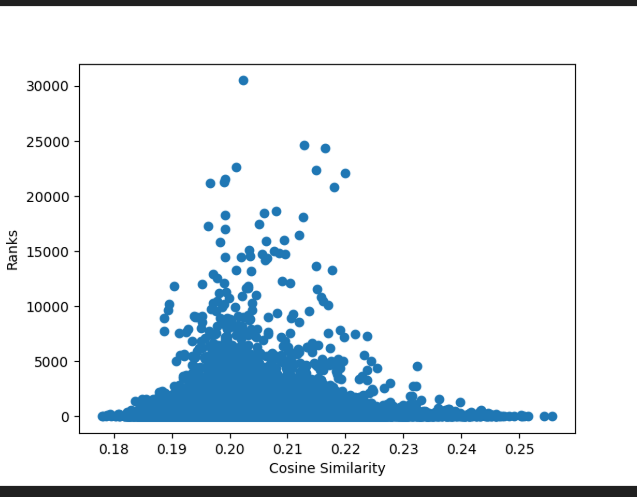



In [ ]:
# Ensemble output based on multiple embeddings.
# For brevity purposes, the code below generates the ensemble output for only
# the training embeddings
'''
inputs = "../softmax_CLIP/embeddings"
dir1 = osp.join(inputs, "GCN1/")
dir2 = osp.join(inputs, "GCN2/")
dir3 = osp.join(inputs, "GCN3/")
dir4 = osp.join(inputs, "MLP1/")
dir5 = osp.join(inputs, "MLP2/")
dir6 = osp.join(inputs, "MLP3/")
dirs = [dir1, dir2, dir3, dir4, dir5, dir6]
'''

NUM_MODELS = len(dirs)

# Do similar for validation and testing if needed.
text_embeddings_train = []
chem_embeddings_train = []

# Declare arrays for validation and testing if needed.
cids_train = []

for i, dir in enumerate(dirs):
    cids_train.append(np.load(osp.join(dir, "cids_train.npy"), allow_pickle=True))
    text_embeddings_train.append(np.load(osp.join(dir, "text_embeddings_train.npy")))
    chem_embeddings_train.append(np.load(osp.join(dir, "chem_embeddings_train.npy")))
    print('Loaded embedding from model', i+1)

for i in range(1, NUM_MODELS):
    tmp = cids_train[i].tolist()
    indexes = [tmp.index(i) for i in cids_train[0]]

    cids_train[i] = cids_train[i][indexes]

    text_embeddings_train[i] = text_embeddings_train[i][indexes]

    chem_embeddings_train[i] = chem_embeddings_train[i][indexes]

    print('Embeddings {} reordered'.format(i+1))

print('Sorted embeddings')

#combine all splits:
all_text_embbedings = []
all_mol_embeddings = []
for i in range(NUM_MODELS):
    all_text_embbedings.append(np.concatenate(text_embeddings_train[i], axis = 0))
    all_mol_embeddings.append(np.concatenate(chem_embeddings_train[i], axis = 0))

all_cids = np.concatenate(cids_train[0], axis = 0)

n_train = len(cids_train[0])
n = n_train

def memory_efficient_similarity_matrix_custom(func, embedding1, embedding2, chunk_size = 1000):
    rows = embedding1.shape[0]

    num_chunks = int(np.ceil(rows / chunk_size))

    for i in range(num_chunks):
        end_chunk = (i+1)*(chunk_size) if (i+1)*(chunk_size) < rows else rows
        yield func(embedding1[i*chunk_size:end_chunk,:], embedding2)

text_chem_cos = []
text_chem_cos_val = []
text_chem_cos_test = []
for i in range(NUM_MODELS):
    text_chem_cos.append(memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_train[i], all_mol_embeddings[i]))
    text_chem_cos_val.append(memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_val[i], all_mol_embeddings[i]))
    text_chem_cos_test.append(memory_efficient_similarity_matrix_custom(cosine_similarity, text_embeddings_test[i], all_mol_embeddings[i]))

tr_avg_ranks = np.zeros((n_train, n))
ranks_train = []

def get_ranks(text_chem_cos, ranks_avg, offset, split= ""):
    ranks_tmp = []
    j = 0 #keep track of all loops
    for l, emb in enumerate(text_chem_cos):
        for k in range(emb.shape[0]):
            cid_locs = np.argsort(emb[k,:])[::-1]
            ranks = np.argsort(cid_locs)

            ranks_avg[j,:] = ranks_avg[j,:] + ranks

            rank = ranks[j+offset] + 1
            ranks_tmp.append(rank)

            j += 1
            if j % 1000 == 0: print(j, split+" processed")

    return np.array(ranks_tmp)

def print_ranks(ranks, model_num, split):

    print(split+" Model {}:".format(model_num))
    print("Mean rank:", np.mean(ranks))
    print("Hits at 1:", np.mean(ranks <= 1))
    print("Hits at 10:", np.mean(ranks <= 10))
    print("Hits at 100:", np.mean(ranks <= 100))
    print("Hits at 500:", np.mean(ranks <= 500))
    print("Hits at 1000:", np.mean(ranks <= 1000))

    print("MRR:", np.mean(1/ranks))
    print()

for i in range(NUM_MODELS):
    ranks_tmp = get_ranks(text_chem_cos[i], tr_avg_ranks, offset=0, split="train")
    print_ranks(ranks_tmp, i+1, split="Training")
    ranks_train.append(ranks_tmp)

#Process ensemble:
sorted = np.argsort(tr_avg_ranks)
new_tr_ranks = np.diag(np.argsort(sorted)) + 1

print_ranks(new_tr_ranks, "e", split="Training Ensemble")

Here is example output of the ensemble command, for the MLP Model and GCN Model. The ouputs here are for the two models that have been trained for 2 epochs with batch_size as 32.

Training Model 1:
Mean rank: 299.47837776431385
Hits at 1: 0.01673735231747955
Hits at 10: 0.12799151772190245
Hits at 100: 0.5427900636170857
Hits at 500: 0.8639427446228416
Hits at 1000: 0.938579218418661
MRR: 0.057560443722529685

Training Model 2:
Mean rank: 375.6514692517419
Hits at 1: 0.01219327476522266
Hits at 10: 0.09622084216903969
Hits at 100: 0.4447137231142078
Hits at 500: 0.8117615873977583
Hits at 1000: 0.920365040896698
MRR: 0.044266726660049036


## Model comparison

In [ ]:
# compare you model with others
# you don't need to re-run all other experiments, instead, you can directly refer the metrics/numbers in the paper

# Discussion - Instructions

**TODO:** *remove this before submitting*

In this section,you should discuss your work and make future plan. The discussion should address the following questions:
  * Make assessment that the paper is reproducible or not.
  * Explain why it is not reproducible if your results are kind negative.
  * Describe “What was easy” and “What was difficult” during the reproduction.
  * Make suggestions to the author or other reproducers on how to improve the reproducibility.
  * What will you do in next phase.



# Discussion

The code in the paper was reproducible although we had great difficulty with one portion (extracting the multi-head attention). There are aspects of the paper (specifically calling out MLP1, 2, 3 and GCN1, 2, 3) that are quite confusing.

## What was easy?

* The authors made it easy with both Python and Jupyter notebooks.
* While the dataset was mislabeled in the GitHub repository, it was fully available.
* The paper and the subject are approachable.

## What was difficult?

* The code from the authors was mostly uncommented and generally poorly written. In particular, code was duplicated in numerous places with minor, unexplained differences.
* One particular section of code extracting the multi-head attention weights relied upon an older form of PyTorch. The code was extremely poorly commented, so it was hard to understand what the authors intended. This took the better part of a week to debug. If the authors had supplied a requirements.txt file, it would have been easier to fix.
* The code was additionally extremely unoptimized. A minor tweak to the loss computation by keeping the values on the GPU decreased step time by 10%.

## Suggestions to the authors

* Functions are your friends. Inheritance is even better. Try refactoring your code to make it easier to understand and profile.
* Try performance profiling your code, you will find multiple instances where you can get 10% to 3x performance improvements.
* The paper and the code does not adequately explain MLP1, MLP2, MLP3 and GCN1, GCN2, GCN3.

## Next phase

In the final phase of the project, we want to finish up the code to include all of the association rules.

Originaly we planned 5 different ablations
1. Use BERT instead of SciBERT to gauge the impact.
1. Remove the learned temperature parameter from the general loss function to gauge the impact.
1. Remove negative sampling from the loss function for the cross-modal attention model to gauge the impact.
1. Use one token for each atom (r = 0) instead of two to gauge the impact.
1. Remove layer normalization from the encoders to gauge the impact.

We will attempt each of these to see the difference on the final results.

# References

1. Edwards, Carl & Zhai, ChengXiang & Ji, Heng. (2021). Text2Mol: Cross-Modal Molecule Retrieval with Natural Language Queries. 595-607. 10.18653/v1/2021.emnlp-main.47.

1. Beltagy, I., Lo, K., & Cohan, A. (2019). SciBERT: A Pretrained Language Model for Scientific Text. Conference on Empirical Methods in Natural Language Processing.

1. Jaeger, Sabrina and Fulle, Simone and Turk, Samo. (2018) Mol2vec: Unsupervised Machine Learning Approach with Chemical Intuition. Journal of Chemical Information and Modeling 10.1021/acs.jcim.7b00616

1. Chemical Entities of Biological Interest (ChEBI) https://www.ebi.ac.uk/chebi/downloadsForward.do

1. GitHub Text2Mol repository: https://github.com/cnedwards/text2mol

